A code snippet for benchmark of hypothesis generation

In [18]:
from transformers import pipeline
from sentence_transformers import SentenceTransformer, util
import json 
import random
import re
import ast

# load tool models
emb_model = SentenceTransformer('all-MiniLM-L6-v2')
infer_model = pipeline("text-generation", model="Qwen/Qwen2.5-1.5B-Instruct")


Device set to use cuda:0


In [19]:
# load and embeding hypothesis bank
with open('../open-r1/recipes/hypoGen/hypothesis_bank2.json', 'r') as f:
    hb = json.load(f)
hypothesis_bank = hb['tweet_hypotheses']
emb_hyp_bank = emb_model.encode(hypothesis_bank, convert_to_tensor=True)

In [20]:
# load dataset
with open('../data/retweet/retweet_test.json', 'r') as f:
    tweet_pairs_dataset = json.load(f)
tweet_pairs_dataset['input'] = [(first, second) for first, second in zip(tweet_pairs_dataset['first_tweet'], tweet_pairs_dataset['second_tweet'])]


In [21]:
with open('../open-r1/recipes/hypoGen/hypothesis_infer.md', 'r') as f:
    infer_template = f.read()

In [22]:
def avg(inp):
    return sum(inp) / len(inp)

    
def get_hypothesis_pred(output):
    match = re.search(r"Final answer: the (first|second) tweet", output)
    if match:
        result = match.group(1)
        return result
    else:
        return None

def get_hypothesis(output):
    match = re.search(r'HYP:\s*(.*?[\.\!\?])', output)
    if match:
        result = match.group(1)
        return result
    else:
        return None

def compute_score(preds, labels):
    correct = sum([t == p for t, p in zip(labels, preds)])
    score = correct / len(labels)
    return score

In [23]:
def get_practical_rewards(new_hypothesis_list, batch_size=10):

    practical_rewards = []
    for hyp in new_hypothesis_list[:10]:
        rewards = []
        print(f'testing :{hyp}\n')
        for i in range(0, len(tweet_pairs_dataset['input']), batch_size):
            llm_input = tweet_pairs_dataset['input'][i:i+batch_size]
            labels = tweet_pairs_dataset['label'][i:i+batch_size]
            if not hyp:
                rewards.append(0)

            else:
                final_prompt = infer_template.format(input=llm_input, hypothesis=hyp)
                output = infer_model(final_prompt, 
                                    max_new_tokens=100, 
                                    num_return_sequences=1,
                                    temperature=0.9, 
                                    do_sample=True)
                output = output[0]['generated_text'].split('## OUTPUT')[-1]
                
                match = re.search(r'\[[^\[\]]*\]', output)
                if match:
                    preds = match.group(0)
                    preds = ast.literal_eval(preds)
                    score = compute_score(preds, labels)
                    rewards.append(score)
                else:
                    rewards.append(0)
        avg_rew = sum(rewards)/len(rewards)
        print(f'avg practical rewards: {avg_rew}')
        practical_rewards.append(avg_rew)
    return practical_rewards

p_rewards_infer = get_practical_rewards(hypothesis_bank, 5)

testing :Tweets with visual content (images or videos) receive more retweets than text-only tweets.

avg practical rewards: 0.5066666666666667
testing :Tweets that include popular hashtags receive more retweets than those without hashtags.

avg practical rewards: 0.4266666666666667
testing :Tweets mentioning influential figures or brands receive more retweets than those that do not.

avg practical rewards: 0.5066666666666666
testing :Tweets with emotionally charged language (e.g., 'shocking', 'amazing') receive more retweets than neutral language.

avg practical rewards: 0.48333333333333334
testing :Tweets containing humor or jokes receive more retweets than serious tweets.

avg practical rewards: 0.48000000000000004
testing :Tweets discussing controversial topics receive more retweets than non-controversial tweets.

avg practical rewards: 0.48333333333333334
testing :Tweets with a clear call-to-action (e.g., 'Retweet this') receive more retweets than those without.

avg practical rewa

In [24]:
print(f'infer model practical avg rewards: {avg(p_rewards_infer)}')

infer model practical avg rewards: 0.48166666666666663


In [25]:
# import openai
# from openai import OpenAI
# import numpy as np
# from tenacity import retry, stop_after_attempt, wait_random_exponential

# # 初始化 OpenAI 客户端
# client = OpenAI(api_key="sk-svcacct-weFv3dteTxkQFpWdzqj7U_Aid4pPEiylunq63VnUVJv3TBdAR0qT3BlbkFJjd6GZZos9Zkd4ux3HRhmGbZt1iY7iJk5U1T28_yXCrBceQRgxdwA")  # 替换为你的 API 密钥

# # 设置重试机制和指数退避
# @retry(stop=stop_after_attempt(3), wait=wait_random_exponential(min=1, max=30))
# def openai_chat_completion(**kwargs):
#     return client.chat.completions.create(**kwargs)

# def get_practical_rewards(new_hypothesis_list, tweet_pairs_dataset, batch_size=10):
#     practical_rewards = []
    
#     # 预处理数据集为可迭代批次
#     dataset_size = len(tweet_pairs_dataset['input'])
#     indices = np.arange(dataset_size)
#     np.random.shuffle(indices)
    
#     # 仅处理前10个假设
#     for hyp_idx, hyp in enumerate(new_hypothesis_list[:10]):
#         if not hyp.strip():
#             practical_rewards.append(0)
#             continue
            
#         total_score = []
#         print(f"\nTesting hypothesis {hyp_idx+1}/10: {hyp[:50]}...")
        
#         # 分批处理数据
#         for batch_start in range(0, dataset_size, batch_size):
#             batch_indices = indices[batch_start : batch_start+batch_size]
#             batch_inputs = [tweet_pairs_dataset['input'][i] for i in batch_indices]
#             batch_labels = [tweet_pairs_dataset['label'][i] for i in batch_indices]
#             batch_scores = []
#             try:
#                 messages = [
#                         {"role": "system", "content": "You are a tweet analysis expert."},
#                         {"role": "user", "content": infer_template.format(
#                             input=batch_inputs, 
#                             hypothesis=hyp
#                         )}
#                     ]
#                 response = openai_chat_completion(
#                         model="gpt-4o",  # 或 "gpt-4"
#                         messages=messages,
#                         max_tokens=100,
#                         temperature=0.9,
#                         n=1
#                     )
#                 # 每个prompt仅处理一个例子
#                 # 构造批量请求消息
#                 # messages_batch = []
#                 # for input_text in batch_inputs:
#                 #     messages = [
#                 #         {"role": "system", "content": "You are a tweet analysis expert."},
#                 #         {"role": "user", "content": infer_template.format(
#                 #             input=input_text, 
#                 #             hypothesis=hyp
#                 #         )}
#                 #     ]
#                 #     messages_batch.append(messages)
                
#                 # # 批量API调用
#                 # responses = []
#                 # for messages in messages_batch:
#                 #     response = openai_chat_completion(
#                 #         model="gpt-4o",  # 或 "gpt-4"
#                 #         messages=messages,
#                 #         max_tokens=100,
#                 #         temperature=0.9,
#                 #         n=1
#                 #     )
#                 #     responses.append(response.choices[0].message.content)
                
               
                
#                 output = response.choices[0].message.content.split('## OUTPUT')[-1].strip()
#                 match = re.search(r'\[[^\[\]]*\]', output)
                
#                 if match:
#                     try:
#                         preds = ast.literal_eval(match.group(0))
#                         batch_score = compute_score(preds, batch_labels)
#                     except:
#                         batch_score = 0
#                 else:
#                     batch_score = 0

#                 # print(f"Batch {batch_start//batch_size+1} | Avg score: {batch_score}")
#                 total_score.append(batch_score)
#             except Exception as e:
#                 print(f"Error processing batch {batch_start//batch_size+1}: {str(e)}")
#                 continue
               
#         # 计算平均奖励
#         avg_reward = avg(total_score) 
#         practical_rewards.append(avg_reward)
#         print(f"Hypothesis {hyp_idx+1} Final Avg Reward: {avg_reward:.4f}")
    
#     return practical_rewards

# # 使用示例
# p_rewards_api = get_practical_rewards(
#     hypothesis_bank,
#     tweet_pairs_dataset,
#     batch_size=10  # 根据API速率限制调整
# )

In [26]:
print(p_rewards_infer)

[0.5066666666666667, 0.4266666666666667, 0.5066666666666666, 0.48333333333333334, 0.48000000000000004, 0.48333333333333334, 0.5133333333333333, 0.4666666666666667, 0.48000000000000004, 0.47]


In [27]:
p_rewards_infer_qwen1s5_batch10 = [0.48000000000000004, 0.53, 0.5433333333333333, 0.5066666666666666, 0.4966666666666667, 0.5666666666666667, 0.5466666666666666, 0.4666666666666667, 0.53, 0.5]
p_rewards_infer_qwen7_batch10 = [0.5399999999999999, 0.6, 0.55, 0.56, 0.5133333333333333, 0.5466666666666666, 0.55, 0.61, 0.4933333333333333, 0.5433333333333333]
p_rewards_infer_qwen1s5_batch1 = [0.54, 0.4766666666666667, 0.49666666666666665, 0.5466666666666666, 0.5, 0.5233333333333333, 0.5133333333333333, 0.49666666666666665, 0.5066666666666667, 0.5133333333333333]
p_rewards_infer_qwen1s5_batch20 = [0.4166666666666667, 0.4566666666666667, 0.36333333333333334, 0.2966666666666667, 0.41333333333333333, 0.3466666666666667, 0.45, 0.43333333333333335, 0.37, 0.3466666666666667]
p_rewards_api = [0.5433333333333333, 0.5333333333333333, 0.5700000000000001, 0.6533333333333332, 0.5133333333333333, 0.58, 0.5666666666666667, 0.56, 0.5666666666666667, 0.5633333333333332]

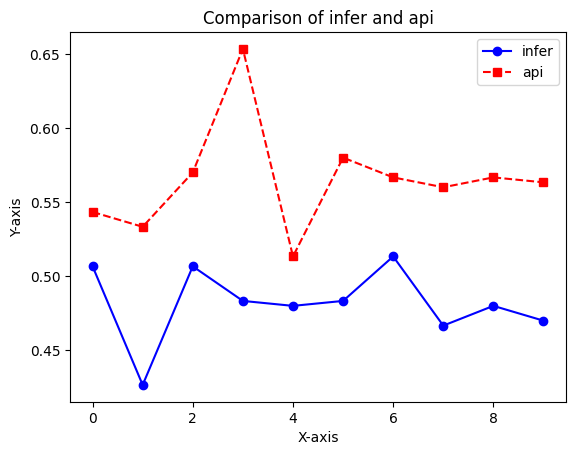

In [28]:
import matplotlib.pyplot as plt



# 创建图形
plt.plot(p_rewards_infer, marker='o', linestyle='-', color='b', label='infer')  # 绘制 infer 线
plt.plot(p_rewards_api, marker='s', linestyle='--', color='r', label='api')     # 绘制 api 线

# 添加标题和标签
plt.title('Comparison of infer and api')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# 显示图例
plt.legend()
plt.savefig('batch5-qwen1.5b.jpg')
# 显示图形
plt.show()